<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#mlp-regression" data-toc-modified-id="mlp-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>mlp regression</a></span></li><li><span><a href="#regularized-mlp-regression" data-toc-modified-id="regularized-mlp-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>regularized mlp regression</a></span></li><li><span><a href="#pinn" data-toc-modified-id="pinn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>pinn</a></span></li></ul></div>

# setup

In [59]:
import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_squared_error

from IPython.display import display

%matplotlib inline

# data

<!-- **medidas** <br/> de [Lab 6: Simple Harmonic Oscillators](https://www.studocu.com/en-us/document/the-city-college-of-new-york/general-physics-i/lab-6-simple-harmonic-oscillators/27226380)

| $Time(s)$ | $Position (m)$ | $Velocity (m s^{-1})$ | Acceleration ($m s^{-2}$) |
|:-----------:|:---------------:|:-----------------:|:-----------------------:|
|      0      |     0.181104    |     -0.003521     |        0.0107877        |
|     0.5     |    0.1808296    |      -0.00048     |        -0.016009        |
|      1      |    0.1808296    |     0.0563435     |        0.9898961        |
|     1.5     |    0.2458624    |     0.0782269     |         1.068586        |
|      2      |     0.208544    |     -0.279888     |         0.698207        |
|     2.5     |    0.1808296    |     0.0872821     |        1.2009078        |
|      3      |     0.297724    |     0.0721215     |         -1.22394        |

Spring Constant: k = 16.16
Length of Spring: 0.18m
Length of Spring (Stretched): 0.787m
X= 0.607 

data = [
    [0, 0.181104, -0.003521, 0.0107877],
    [0.5, 0.1808296, -0.00048, -0.016009],
    [1, 0.1808296, 0.0563435, 0.9898961],
    [1.5, 0.2458624, 0.0782269, 1.068586],
    [2, 0.208544, -0.279888, 0.698207],
    [2.5, 0.1808296, 0.0872821, 1.2009078],
    [3, 0.297724, 0.0721215, -1.22394]
]

pd.DataFrame(data, columns=["t", "x", "v", "a"])
-->

**medidas** <br/> [Damped Harmonic Oscillator Dataset by Cecília Coelho](https://www.kaggle.com/datasets/cici118/damped-harmonic-oscillator)

* $m = 1kg$
* $k = 1 N m^{-1}$
* $\mu = 0.1 N s m^{-1}$
* $x_0 = 1 m$
* $v_0 = 0 m s^{-1}$

,time,displacement,velocity,acceleration
0,0.000000,1.000000,0.000000,-1.000000
1,1.507538,0.106701,-0.926586,-0.014042
2,3.015075,-0.847175,-0.111879,0.858363
3,4.522613,-0.194060,0.783410,0.115719
4,6.030151,0.705190,0.190814,-0.724272
...,...,...,...,...
62,93.467340,0.005460,0.007311,-0.006191
63,94.974880,0.007356,-0.004957,-0.006861
64,96.482414,-0.003808,-0.006886,0.004496
65,97.989950,-0.006787,0.003432,0.006444


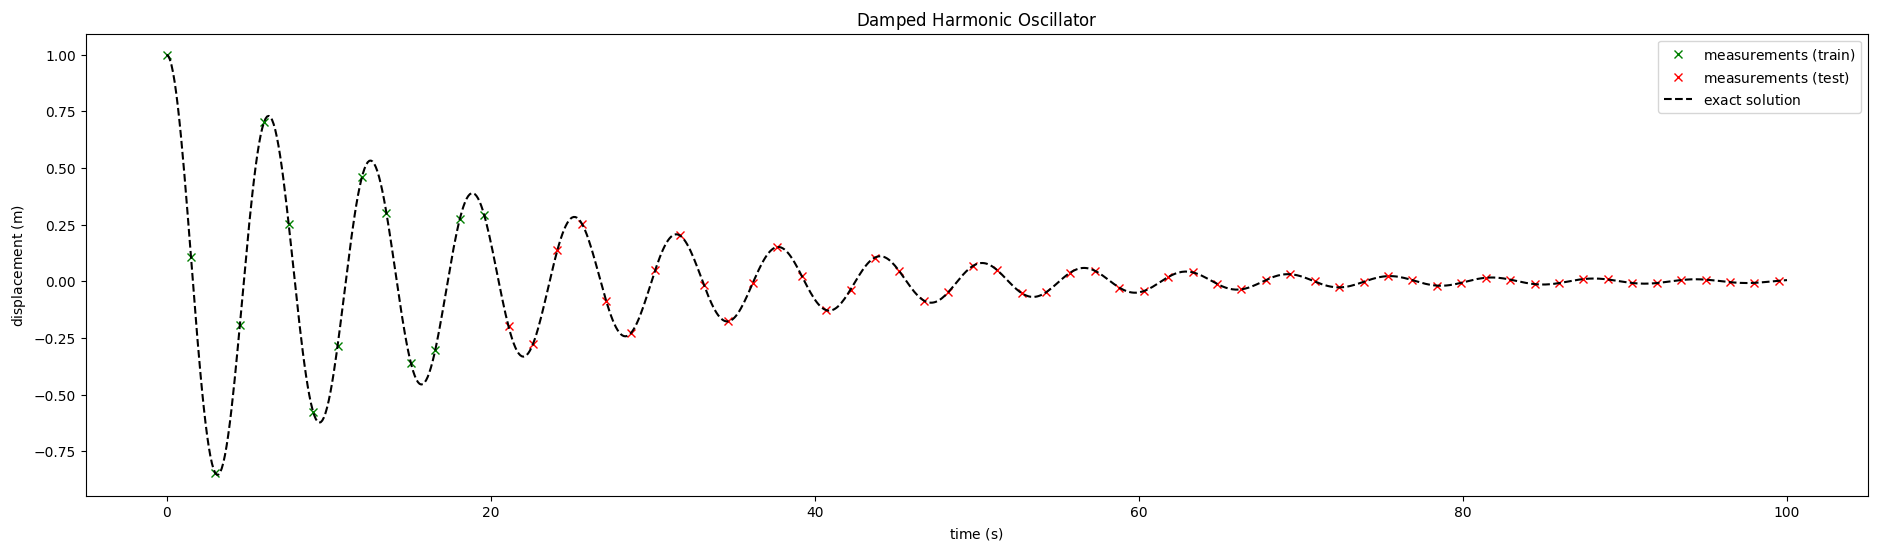

In [60]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 100")
display(X)

# plot experimental data
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 20").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 20 and time <= 100").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 100, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    t, 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico.png", dpi=300, bbox_inches="tight") ;

In [61]:
x_train = torch.tensor(X.query("time <= 20")["time"].values).float().unsqueeze(1)
y_train = torch.tensor(X.query("time <= 20")["displacement"].values).float().unsqueeze(1)

x_test = torch.tensor(X.query("time > 20 and time <= 100")["time"].values).float().unsqueeze(1)
y_test = torch.tensor(X.query("time > 20 and time <= 100")["displacement"].values).float().unsqueeze(1)

# mlp regression

In [82]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33)

learning_rate = 0.001
num_epochs = 100

model = MultiLayerPerceptronRegressor([1] + [16 for _ in range(8)] + [1], nn.ReLU)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

plot_loss_train = dict(epoch=[], loss=[])

for epoch in range(num_epochs):
    # forward
    y_train_hat = model(x_train)
    loss = criterion(y_train_hat, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["loss"].append(loss.item())


epoch [00010/00100] loss: 0.2407
epoch [00020/00100] loss: 0.2405
epoch [00030/00100] loss: 0.239
epoch [00040/00100] loss: 0.2376
epoch [00050/00100] loss: 0.2358
epoch [00060/00100] loss: 0.233
epoch [00070/00100] loss: 0.228
epoch [00080/00100] loss: 0.2217
epoch [00090/00100] loss: 0.213
epoch [00100/00100] loss: 0.2019


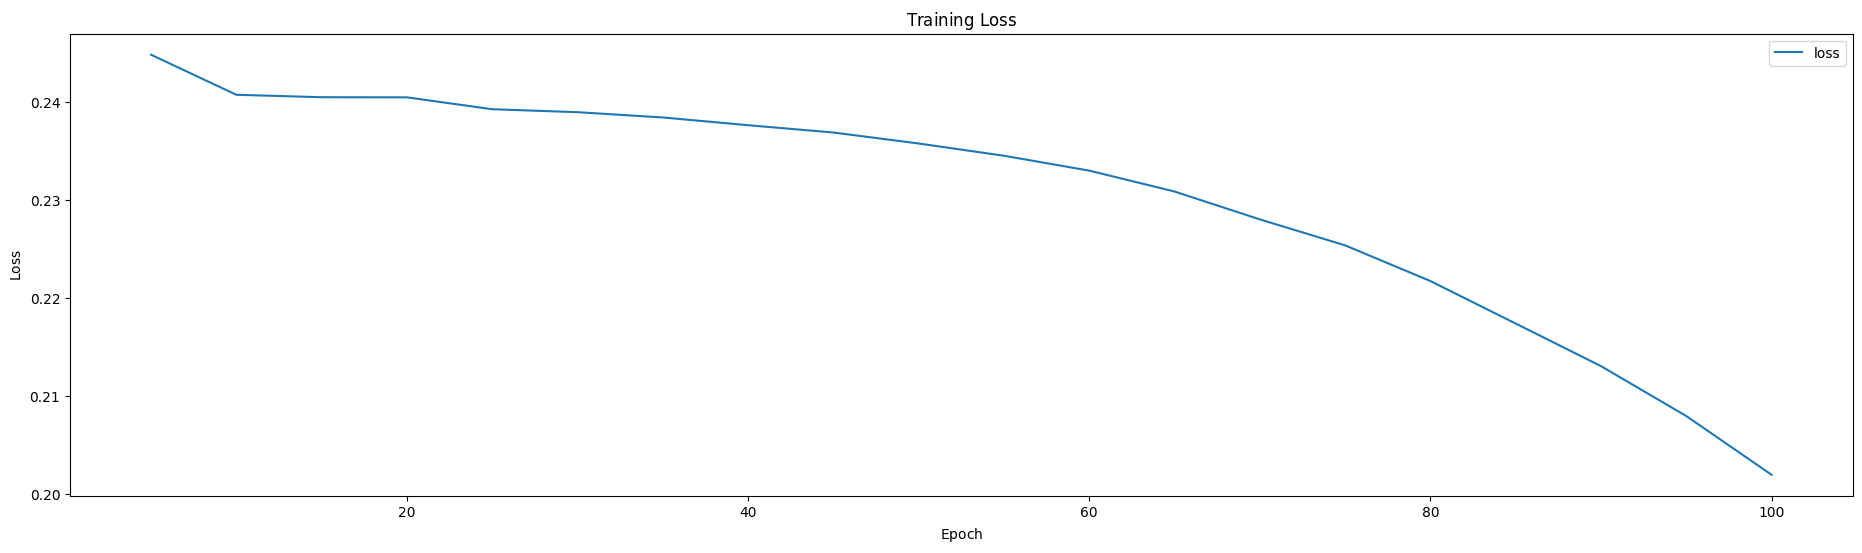

In [83]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="loss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss.png", dpi=300, bbox_inches="tight") ;

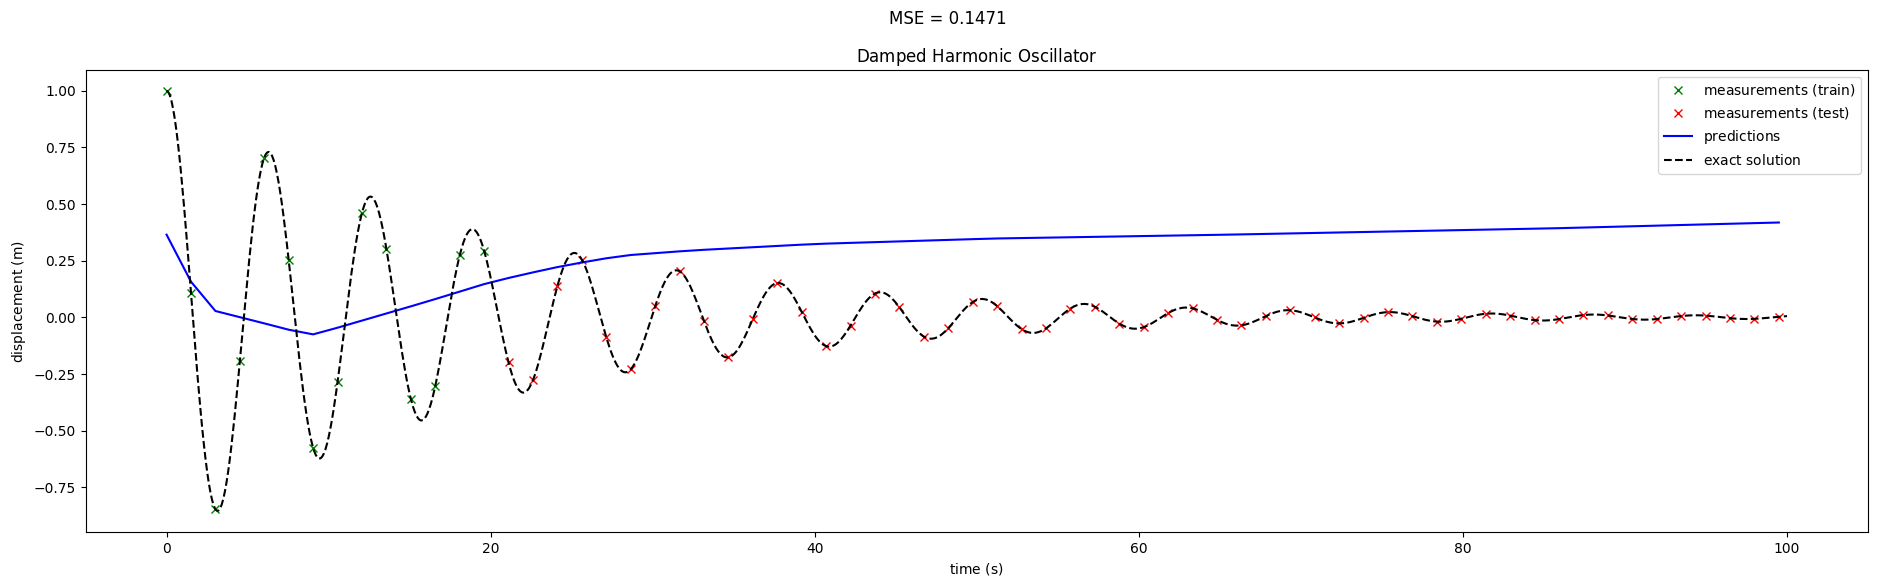

In [84]:
X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1)).detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 20").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 20 and time <= 100").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 100, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    t, 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions.png", dpi=300, bbox_inches="tight") ;

# regularized mlp regression

In [ ]:
# Define the MLP architecture
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLPRegression, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for regression output
        return x

# Hyperparameters
input_dim = 10  # Example input dimension
hidden_dim1 = 64
hidden_dim2 = 32
output_dim = 1
learning_rate = 0.001
l2_reg = 0.01
num_epochs = 100

# Initialize the model, loss, and optimizer
model = MLPRegression(input_dim, hidden_dim1, hidden_dim2, output_dim)
criterion = nn.MSELoss()  # Mean squared error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)  # L2 regularization is done using weight_decay

# Example training loop (dummy data)
for epoch in range(num_epochs):
    # Generate random data
    inputs = torch.randn(32, input_dim)
    targets = torch.randn(32, output_dim)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# pinn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Neural Network architecture
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, t):
        t = self.tanh(self.fc1(t))
        t = self.tanh(self.fc2(t))
        t = self.fc3(t)
        return t

# Loss for the Physics-Informed Neural Network
def physics_informed_loss(model, t, omega):
    # Compute the prediction
    x = model(t)
    # Compute the first derivative w.r.t. time
    x_t = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    # Compute the second derivative w.r.t. time
    x_tt = torch.autograd.grad(x_t, t, grad_outputs=torch.ones_like(x_t), create_graph=True)[0]
    # Harmonic oscillator differential equation
    loss = ((x_tt + omega**2 * x)**2).mean()
    return loss

# Hyperparameters
input_dim = 1
hidden_dim = 50
output_dim = 1
learning_rate = 0.001
l2_reg = 0.01
omega = 1.0  # Adjust as needed

model = PINN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

# Training loop
epochs = 5000
for epoch in range(epochs):
    # Random samples for training
    t = torch.rand(32, 1) * 4 * 3.14159  # Random time values
    t.requires_grad = True

    optimizer.zero_grad()
    loss = physics_informed_loss(model, t, omega)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Once trained, you can predict displacement x for any time t using model(t)
